In [1]:
import pandas as pd
import numpy as np

In [2]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

In [3]:
# sales_of_company_x = pd.read_csv("../Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("../Series/monthly-boston-armed-robberies-j.csv")
# airlines_passengers = pd.read_csv("../Series/international-airline-passengers.csv")
# mean_monthly_temp = pd.read_csv("../Series/mean-monthly-air-temperature-deg.csv")
# dowjones_closing = pd.read_csv("../Series/weekly-closings-of-the-dowjones-.csv")
# female_births = pd.read_csv("../Series/daily-total-female-births-in-cal.csv")

# Необходимые функции

## Коррелограмма

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

## Тест Дики-Фуллера 

* p-value > 0.05 - временной ряд нестационарный
* p-value <=0.05 - временной ряд стационарны

In [5]:
################
 # Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Как выглядят данные?

In [6]:
robberies_in_boston

,Month,Count
0,1966-01,41
1,1966-02,39
2,1966-03,50
3,1966-04,40
4,1966-05,43
...,...,...
113,1975-06,316
114,1975-07,398
115,1975-08,394
116,1975-09,431


In [7]:
robberies_in_boston.shape

(118, 2)

In [8]:
# from datetime import datetime
# robberies_in_boston['Month'] = pd.to_datetime(robberies_in_boston['Month'])

In [9]:
X_train = np.array([i+1 for i in range(-1, 93)], ndmin=2).reshape(94,1)
y_train = np.array(robberies_in_boston['Count'][0:94])
X_train.shape, y_train.shape

((94, 1), (94,))

In [10]:
X_test = np.array([i+1 for i in range(94, 118)], ndmin=2).reshape(24,1)
y_test = np.array(robberies_in_boston['Count'][94:])
X_test.shape, y_test.shape

((24, 1), (24,))

In [11]:
# [i+1 for i in range(94)]

In [12]:
# Т.к. это временные ряды, то замешивать данные нельзя. Разбиваем данные в ручную.
# X_train, y_train, X_test, y_test = robberies_in_boston['Month'][0:94], robberies_in_boston['Count'][0:94], robberies_in_boston['Month'][94:], robberies_in_boston['Count'][94:]

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
from scipy.stats import boxcox

### Преобразование Бокса-Кокса.

Если данные не проходят тест на нормальность, то можно воспользоваться преобразованием Бокса-Кокса.
Если данные $ x = \{x_1, x_2, \dots x_n\}, x_i>0 $, то они будут преобразованны по следующей формуле: 
$$ 
x_i^\lambda = \begin{cases}
                \frac{x_i^\lambda - 1}{\lambda}, &\text{если $ \lambda \ne 0 $;}\\
                \log(x_i), &\text{если $\lambda=0$}\\
                \end{cases}
$$
Другими словами, если мы передаём в функцию параметр $\lambda = 0$, то мы просто логарифмируем данные.

# Monthly Boston armed robberies

## ARIMA

In [15]:
robberies = boxcox(robberies_in_boston['Count'], 0)

In [16]:
# rolling_robberies = robberies_in_boston['Count'].rolling(window=12).mean()

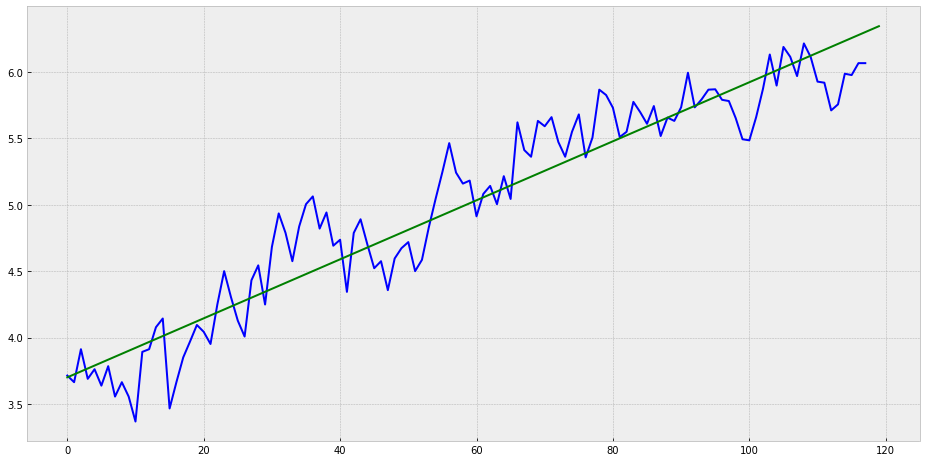

In [17]:
with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        plt.plot(robberies, color='blue')
        # выделим тренд, добавив линию, параметры подобранны.
        plt.plot([x/45 + 3.7 for x in range(120)], color='green')

In [18]:
test_stationarity(robberies)

Results of Dickey-Fuller Test:
Test Statistic                  -2.013161
p-value                          0.280833
#Lags Used                      10.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


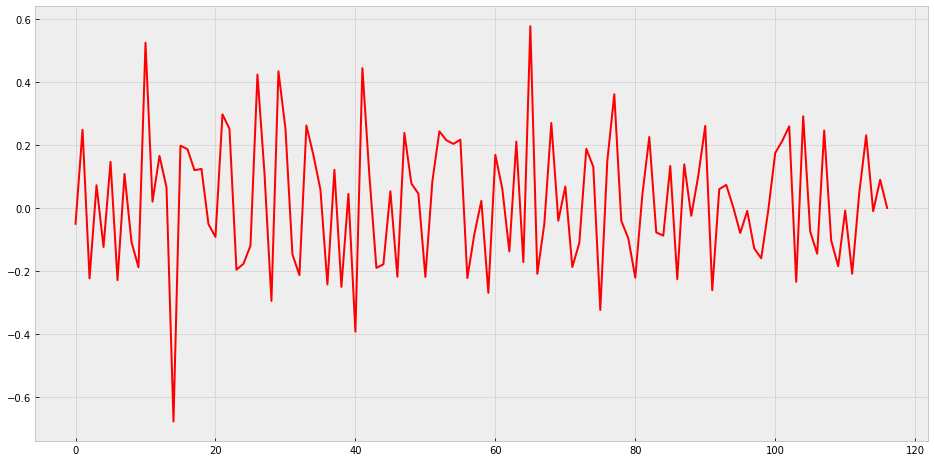

In [19]:
with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        plt.plot(np.diff(robberies), color='red')

In [20]:
test_stationarity(np.diff(robberies))

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


In [21]:
data = np.diff(robberies)

<Figure size 1152x576 with 0 Axes>

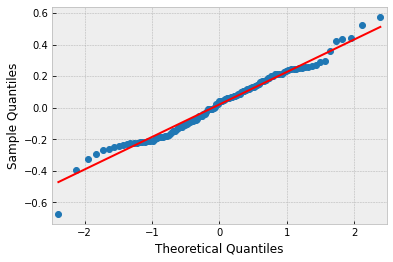

In [22]:
with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        sm.qqplot(data, line='s')

In [23]:
# robberies

In [24]:
from statsmodels.tsa.ar_model import ar_select_order

In [25]:
sel = ar_select_order(data, 13, trend='ct')

In [26]:
sel.ar_lags

[1, 2]

In [27]:
sel_res = sel.model.fit()

In [28]:
print(sel_res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  117
Model:                     AutoReg(2)   Log Likelihood                  24.198
Method:               Conditional MLE   S.D. of innovations              0.196
Date:                Tue, 09 Aug 2022   AIC                            -38.395
Time:                        00:13:37   BIC                            -24.671
Sample:                             2   HQIC                           -32.825
                                  117                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0359      0.038      0.944      0.345      -0.039       0.110
trend         -0.0001      0.001     -0.208      0.836      -0.001       0.001
y.L1          -0.2782      0.090     -3.078      0.0

<Figure size 1152x648 with 0 Axes>

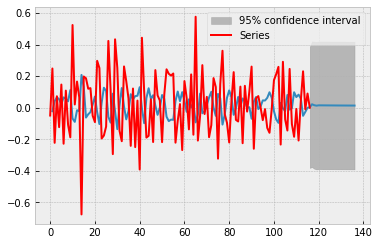

In [29]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16,9))
    sel_res.plot_predict(1, len(data)+20)
    plt.plot(data, color='red', label='Series')
    plt.legend()
    plt.show()

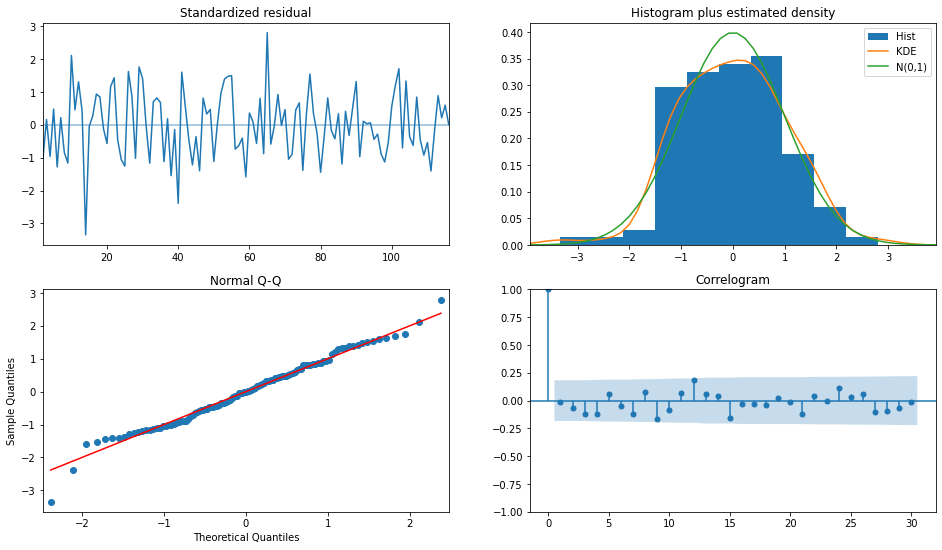

In [30]:
fig = plt.figure(figsize=(16, 9))
fig = sel_res.plot_diagnostics(fig=fig, lags=30)

In [31]:
import statsmodels.tsa.arima.model as arm

In [32]:
# mod = sm.tsa.arima.ARIMA(robberies, order=(1, 1, 0))
mod = arm.ARIMA(data, order=(1,1,0))

In [33]:
res = mod.fit()

In [34]:
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  117
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -15.312
Date:                Tue, 09 Aug 2022   AIC                             34.625
Time:                        00:13:38   BIC                             40.132
Sample:                             0   HQIC                            36.860
                                - 117                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5251      0.078     -6.769      0.000      -0.677      -0.373
sigma2         0.0760      0.010      7.317      0.000       0.056       0.096
Ljung-Box (L1) (Q):                   6.24   Jarque-

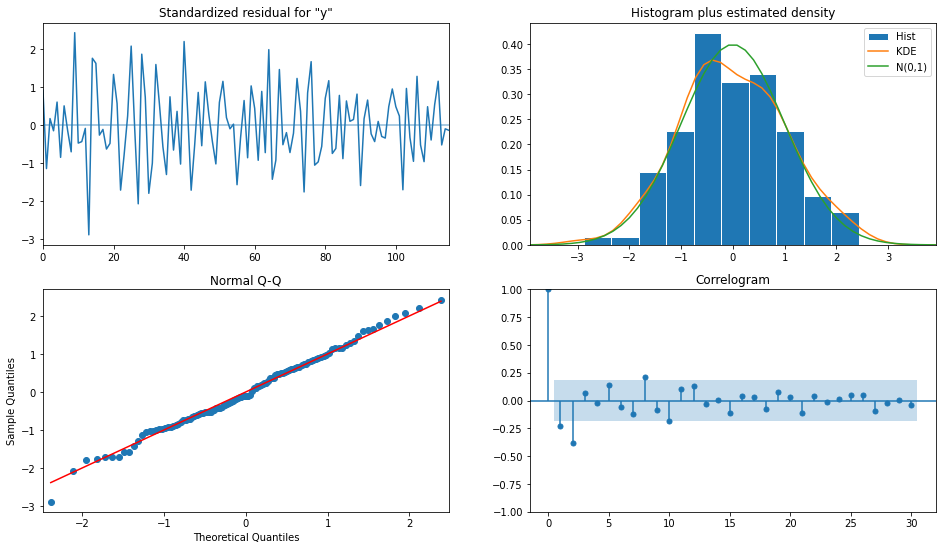

In [35]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

In [36]:
res.predict()

array([ 0.        , -0.05001042,  0.09174162,  0.02448388, -0.08281988,
       -0.0207338 ,  0.00471936, -0.03170518, -0.06876528,  0.00542667,
       -0.14613104,  0.15036904,  0.2850089 ,  0.08921504,  0.11806117,
       -0.28727096, -0.26173183,  0.19248767,  0.15503108,  0.12200048,
        0.04077628, -0.07053457,  0.09296676,  0.2754348 ,  0.03899444,
       -0.18680938, -0.14979841,  0.13821894,  0.27577892, -0.08094874,
        0.05115351,  0.34753507,  0.06269289, -0.17823165,  0.01250124,
        0.21697227,  0.11589001, -0.08428608, -0.06959504, -0.05514799,
       -0.11012242, -0.16280783,  0.00468288,  0.28181776, -0.0361659 ,
       -0.18456053, -0.06869216, -0.07574674, -0.00123962,  0.16208943,
        0.06249285, -0.07988107, -0.07438432,  0.16028563,  0.22993678,
        0.20964383,  0.20987215,  0.00836622, -0.15588338, -0.03262502,
       -0.11588222, -0.0611689 ,  0.11722461, -0.03376499,  0.02789266,
        0.02933017,  0.18396508,  0.20381179, -0.13352608,  0.10

In [37]:
start = len(robberies)
end = start + 10

In [38]:
forecast = res.predict(start=start, end=end)

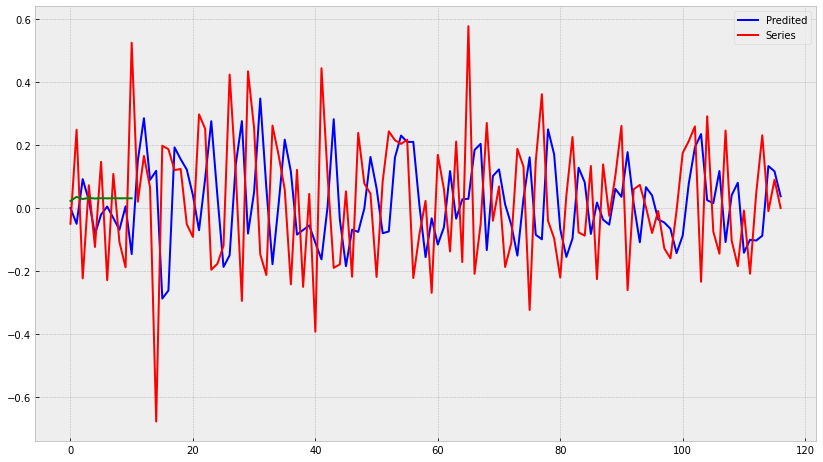

In [39]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    # res.plot_predict(1, len(robberies)+20, ax=ax)
    plt.plot(res.predict(), color='blue', label='Predited')
    plt.plot(data, color='red', label='Series')
    plt.plot(forecast, color='green')
    plt.legend()
    plt.show()

In [40]:
res.get_prediction()

In [41]:
from statsmodels.tools.eval_measures import rmse
error = rmse(data, res.predict())
print(f'ARIMA(1,1,0) RMSE Error: {error}')

ARIMA(1,1,0) RMSE Error: 0.2749718289419455


## Classic ML.

In [42]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [43]:
tree = AdaBoostRegressor(DecisionTreeRegressor(max_depth=6), n_estimators=100, random_state=73)

In [44]:
tree.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=6),
                  n_estimators=100, random_state=73)

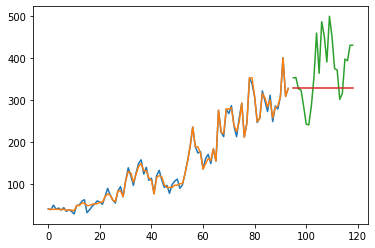

In [45]:
plt.plot(X_train, y_train)
plt.plot(X_train, tree.predict(X_train))
plt.plot(X_test, y_test)
plt.plot(X_test, tree.predict(X_test))

In [46]:
from sklearn import svm

In [47]:
regr = svm.SVR(kernel='linear')

In [49]:
regr.fit(X_train, y_train)

SVR(kernel='linear')

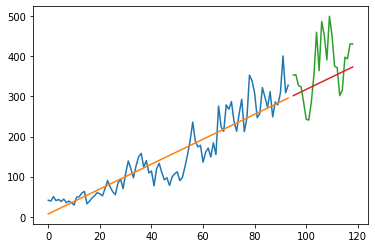

In [50]:
plt.plot(X_train, y_train)
plt.plot(X_train, regr.predict(X_train))
plt.plot(X_test, y_test)
plt.plot(X_test, regr.predict(X_test))